# Assignment

## Instructions

In this assignment, you will apply time series forecasting techniques to analyze and predict future values. You will work with the "Global Temperature Time Series" dataset, which contains monthly temperature anomalies from 1880 to present day.

### Task: Global Temperature Forecasting

Your task is to analyze the global temperature time series and build forecasting models to predict future temperature trends. Follow these steps:

1. **Data Exploration**

   - Load and prepare the dataset
   - Visualize the time series data
   - Check for trends, seasonality, and cycles
   - Create seasonal plots and subseries plots
   - Analyze autocorrelation using ACF plots

2. **Time Series Decomposition**

   - Decompose the time series into trend, seasonal, and residual components
   - Compare additive and multiplicative decomposition methods
   - Interpret your findings

3. **Forecasting**

   - Split the data into training and testing sets using a temporal split
   - Implement and evaluate the following forecasting methods:
     - Naive forecasting (last value and seasonal naive)
     - ARIMA/SARIMA models
     - Exponential smoothing models
   - Use appropriate evaluation metrics (MAE, MAPE, sMAPE) to compare model performance

4. **Model Selection and Interpretation**
   - Determine which model performs best for this dataset
   - Interpret the results and explain why certain models might work better than others
   - Generate forecasts for future periods

### Starter Code

In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

# Load the dataset (NASA GISTEMP Global Temperature Anomaly)
url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"

# Data preparation
def prepare_nasa_data(url):
    # Read the data, skipping the header explanation
    df = pd.read_csv(url, skiprows=1)

    # Remove the unnecessary columns
    df = df.iloc[:, :13]

    # Rename columns
    df.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Convert from wide to long format
    df_long = df.melt(id_vars=['Year'],
                       var_name='Month',
                       value_name='Temperature_Anomaly')

    # Filter out missing or invalid data
    df_long = df_long[df_long['Temperature_Anomaly'] != '***']
    df_long['Temperature_Anomaly'] = df_long['Temperature_Anomaly'].astype(float)

    # Create a proper date index
    df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month'], format='%Y-%b')

    # Sort by date
    df_long = df_long.sort_values('Date')

    # Create a time series
    ts_data = df_long.set_index('Date')['Temperature_Anomaly']

    return ts_data

# Prepare the time series data
ts_data = prepare_nasa_data(url)

# Now you have a time series object 'ts_data' to work with
print(f"Time series data from {ts_data.index.min()} to {ts_data.index.max()}")
print(f"Total number of observations: {len(ts_data)}")

Time series data from 1880-01-01 00:00:00 to 2025-12-01 00:00:00
Total number of observations: 1752


# TODO: Explore and visualize the time series data
# HINT: Use time series plots, seasonal plots, and autocorrelation plots


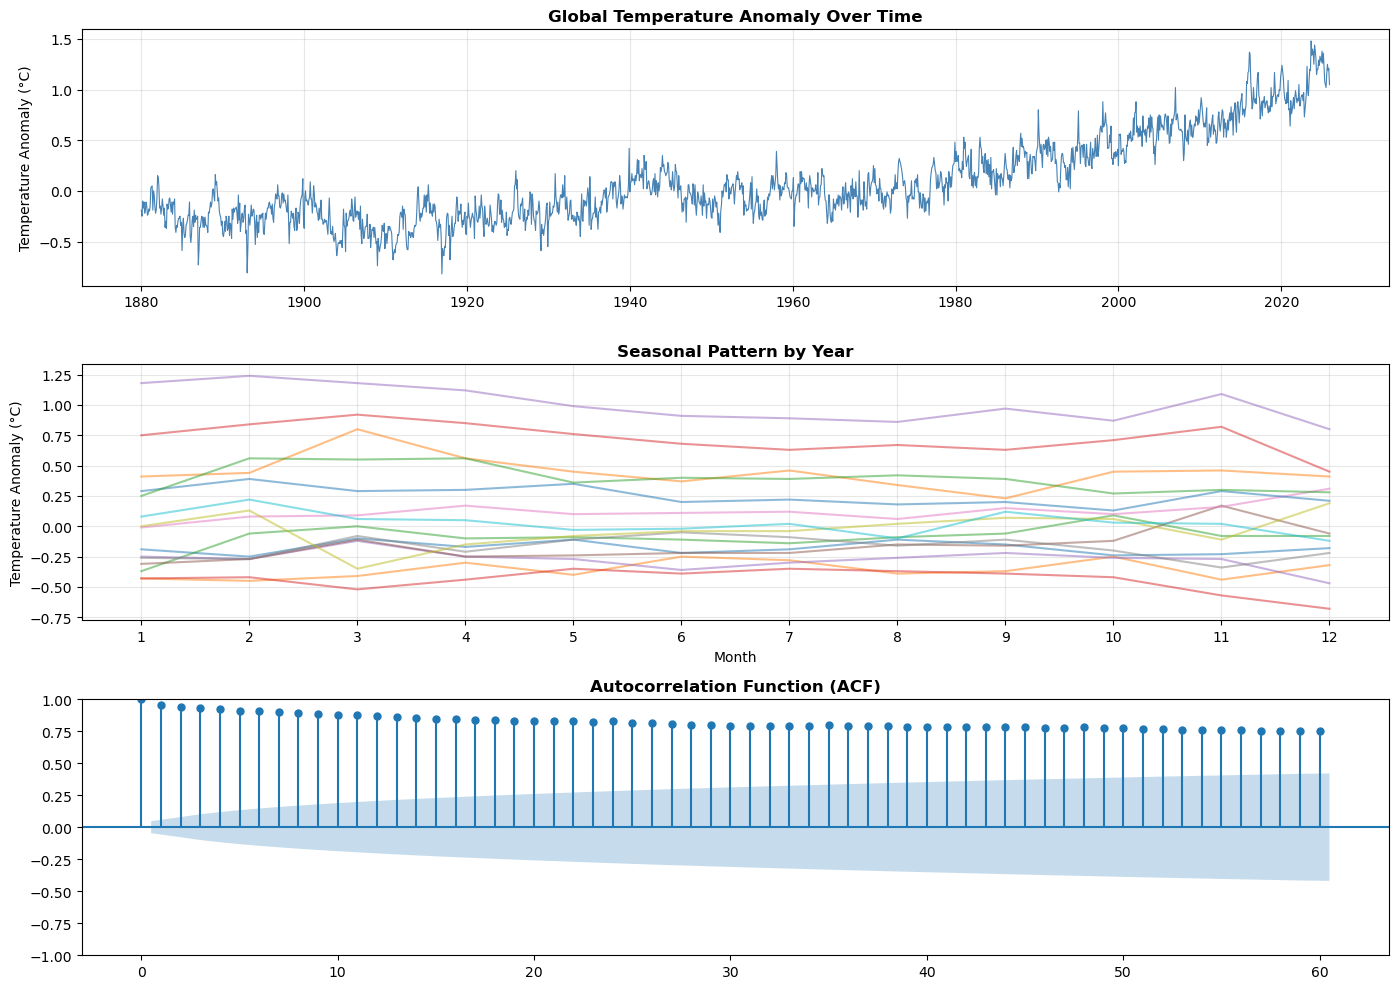

Mean Temperature Anomaly: 0.081°C
Std Dev: 0.415°C
Min: -0.820°C
Max: 1.480°C


In [11]:
# Visualize the time series data
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Time series plot
axes[0].plot(ts_data.index, ts_data.values, linewidth=0.8, color='steelblue')
axes[0].set_title('Global Temperature Anomaly Over Time', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Temperature Anomaly (°C)')
axes[0].grid(True, alpha=0.3)

# 2. Seasonal plot
ts_data_df = ts_data.reset_index()
ts_data_df['Year'] = ts_data_df['Date'].dt.year
ts_data_df['Month'] = ts_data_df['Date'].dt.month

for year in ts_data_df['Year'].unique()[::10]:  # Plot every 10th year
    data = ts_data_df[ts_data_df['Year'] == year]
    axes[1].plot(data['Month'], data['Temperature_Anomaly'], alpha=0.5, label=str(year))

axes[1].set_title('Seasonal Pattern by Year', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Temperature Anomaly (°C)')
axes[1].set_xticks(range(1, 13))
axes[1].grid(True, alpha=0.3)

# 3. Autocorrelation plot
plot_acf(ts_data, lags=60, ax=axes[2])
axes[2].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print basic statistics
print(f"Mean Temperature Anomaly: {ts_data.mean():.3f}°C")
print(f"Std Dev: {ts_data.std():.3f}°C")
print(f"Min: {ts_data.min():.3f}°C")
print(f"Max: {ts_data.max():.3f}°C")

# TODO: Perform time series decomposition
# HINT: Try both additive and multiplicative decomposition

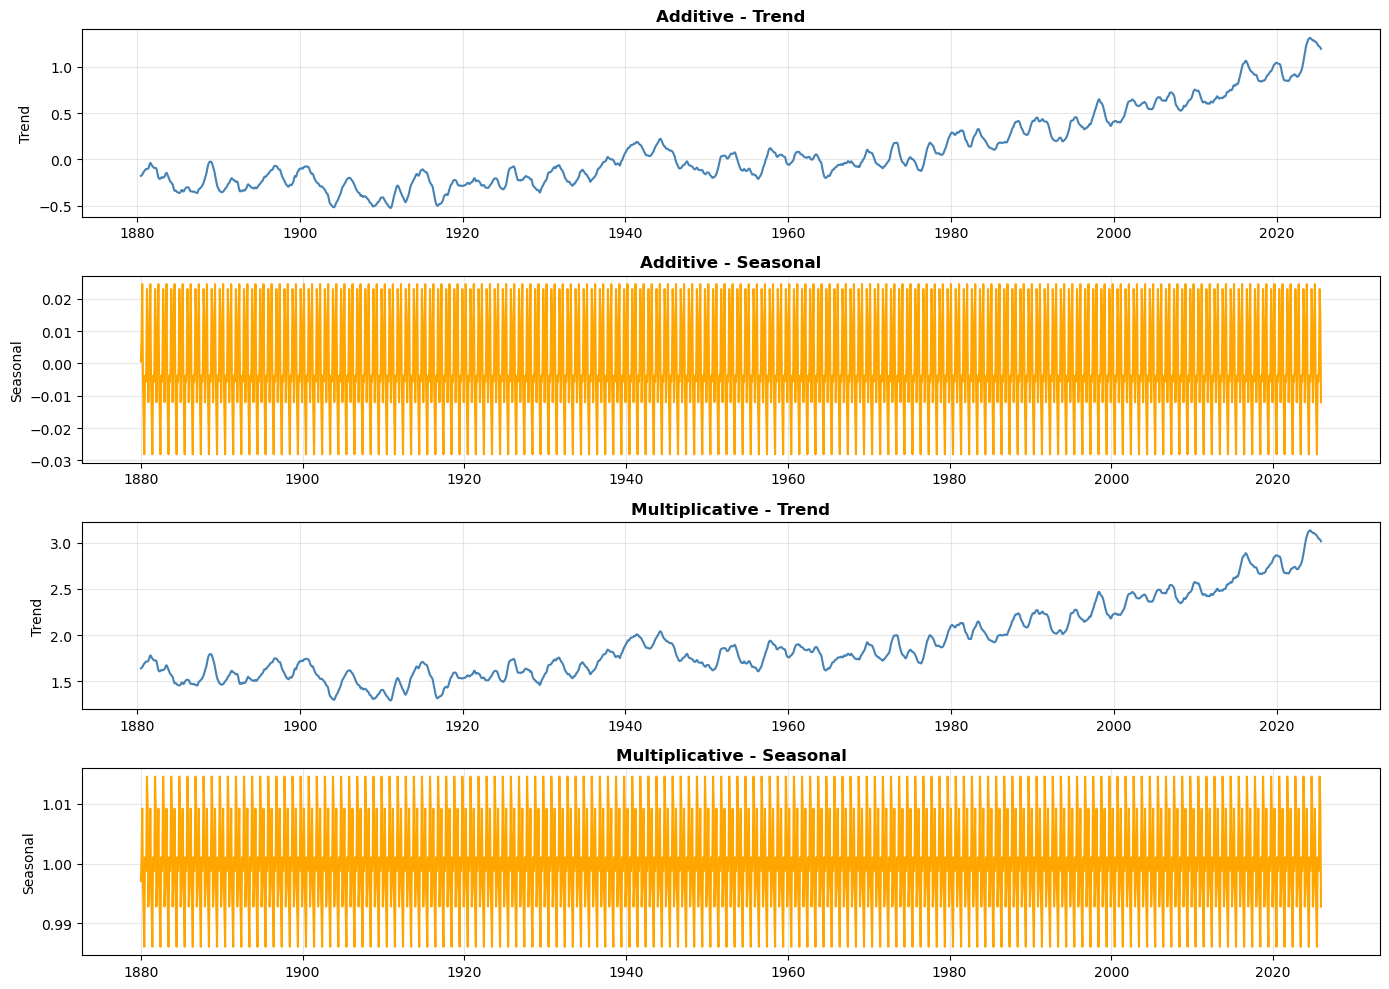

Decomposition Summary:
Additive residuals mean: 0.000015
Multiplicative residuals mean: 0.999714
Data min: -0.820000


In [12]:
# Perform time series decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Additive decomposition
decomposition_add = seasonal_decompose(ts_data, model='additive', period=12)

axes[0].plot(decomposition_add.trend.index, decomposition_add.trend.values, color='steelblue')
axes[0].set_title('Additive - Trend', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Trend')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition_add.seasonal.index, decomposition_add.seasonal.values, color='orange')
axes[1].set_title('Additive - Seasonal', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Seasonal')
axes[1].grid(True, alpha=0.3)

# Multiplicative decomposition
ts_data_shifted = ts_data + abs(ts_data.min()) + 1
decomposition_mul = seasonal_decompose(ts_data_shifted, model='multiplicative', period=12)

axes[2].plot(decomposition_mul.trend.index, decomposition_mul.trend.values, color='steelblue')
axes[2].set_title('Multiplicative - Trend', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Trend')
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition_mul.seasonal.index, decomposition_mul.seasonal.values, color='orange')
axes[3].set_title('Multiplicative - Seasonal', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Seasonal')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Decomposition Summary:")
print(f"Additive residuals mean: {decomposition_add.resid.mean():.6f}")
print(f"Multiplicative residuals mean: {decomposition_mul.resid.mean():.6f}")
print(f"Data min: {ts_data.min():.6f}")

# TODO: Split the data into training and testing sets
# HINT: Use temporal_train_test_split with the last 36 months as test data

Training set size: 1716
Testing set size: 36
Training period: 1880-01-01 00:00:00 to 2022-12-01 00:00:00
Testing period: 2023-01-01 00:00:00 to 2025-12-01 00:00:00


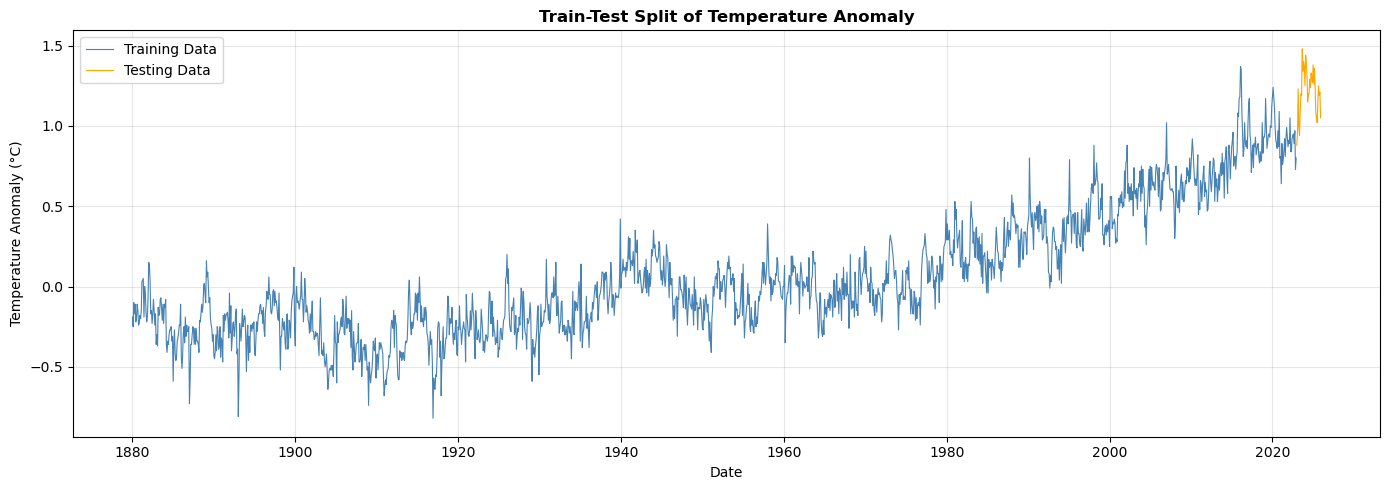

In [13]:
# Split the data into training and testing sets using temporal split
# Use the last 36 months as test data
y_train, y_test = temporal_train_test_split(ts_data, test_size=36)

print(f"Training set size: {len(y_train)}")
print(f"Testing set size: {len(y_test)}")
print(f"Training period: {y_train.index.min()} to {y_train.index.max()}")
print(f"Testing period: {y_test.index.min()} to {y_test.index.max()}")

# Visualize the train-test split
plt.figure(figsize=(14, 5))
plt.plot(y_train.index, y_train.values, label='Training Data', color='steelblue', linewidth=0.8)
plt.plot(y_test.index, y_test.values, label='Testing Data', color='orange', linewidth=0.8)
plt.title('Train-Test Split of Temperature Anomaly', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# TODO: Implement and evaluate different forecasting methods
# HINT: Try naive forecasting, ARIMA, and ETS models

In [14]:
# Initialize a dictionary to store models and their predictions
models = {}
predictions = {}
metrics = {}

# Ensure index is Datetime and set frequency to Monthly
y_train.index = pd.DatetimeIndex(y_train.index).to_period('M')
y_test.index = pd.DatetimeIndex(y_test.index).to_period('M')

# 1. Naive Forecaster (using last value)
print("Training Naive Forecaster...")
naive_model = NaiveForecaster(strategy="last")
naive_model.fit(y_train)
naive_pred = naive_model.predict(fh=range(1, len(y_test) + 1))
predictions['Naive'] = naive_pred
models['Naive'] = naive_model
metrics['Naive'] = mean_absolute_percentage_error(y_test, naive_pred)



Training Naive Forecaster...


In [15]:
# 2. Seasonal Naive Forecaster
print("Training Seasonal Naive Forecaster...")
seasonal_naive_model = NaiveForecaster(strategy="last", sp=12)
seasonal_naive_model.fit(y_train)
seasonal_naive_pred = seasonal_naive_model.predict(fh=range(1, len(y_test) + 1))
predictions['Seasonal Naive'] = seasonal_naive_pred
models['Seasonal Naive'] = seasonal_naive_model
metrics['Seasonal Naive'] = mean_absolute_percentage_error(y_test, seasonal_naive_pred)



Training Seasonal Naive Forecaster...


In [16]:
# 3. AutoARIMA
print("Training AutoARIMA...")
auto_arima_model = AutoARIMA(max_p=5, max_q=5, max_d=2, seasonal=True, sp=12)
auto_arima_model.fit(y_train)
auto_arima_pred = auto_arima_model.predict(fh=range(1, len(y_test) + 1))
predictions['AutoARIMA'] = auto_arima_pred
models['AutoARIMA'] = auto_arima_model
metrics['AutoARIMA'] = mean_absolute_percentage_error(y_test, auto_arima_pred)



Training AutoARIMA...


/home/pocl/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/pocl/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/pocl/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/pocl/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/pocl/miniconda3/envs/ml/lib/py

In [17]:
# 4. Exponential Smoothing
print("Training Exponential Smoothing...")
exp_smooth_model = ExponentialSmoothing(trend="add", seasonal="add", sp=12)
exp_smooth_model.fit(y_train)
exp_smooth_pred = exp_smooth_model.predict(fh=range(1, len(y_test) + 1))
predictions['Exponential Smoothing'] = exp_smooth_pred
models['Exponential Smoothing'] = exp_smooth_model
metrics['Exponential Smoothing'] = mean_absolute_percentage_error(y_test, exp_smooth_pred)



Training Exponential Smoothing...


# TODO: Compare model performance using appropriate metrics
# HINT: Use sMAPE or MAPE to evaluate and compare models

# TODO: Generate and visualize forecasts with the best performing model



MODEL PERFORMANCE COMPARISON (MAPE)
Seasonal Naive            MAPE: 0.2544
AutoARIMA                 MAPE: 0.2780
Exponential Smoothing     MAPE: 0.3021
Naive                     MAPE: 0.3306


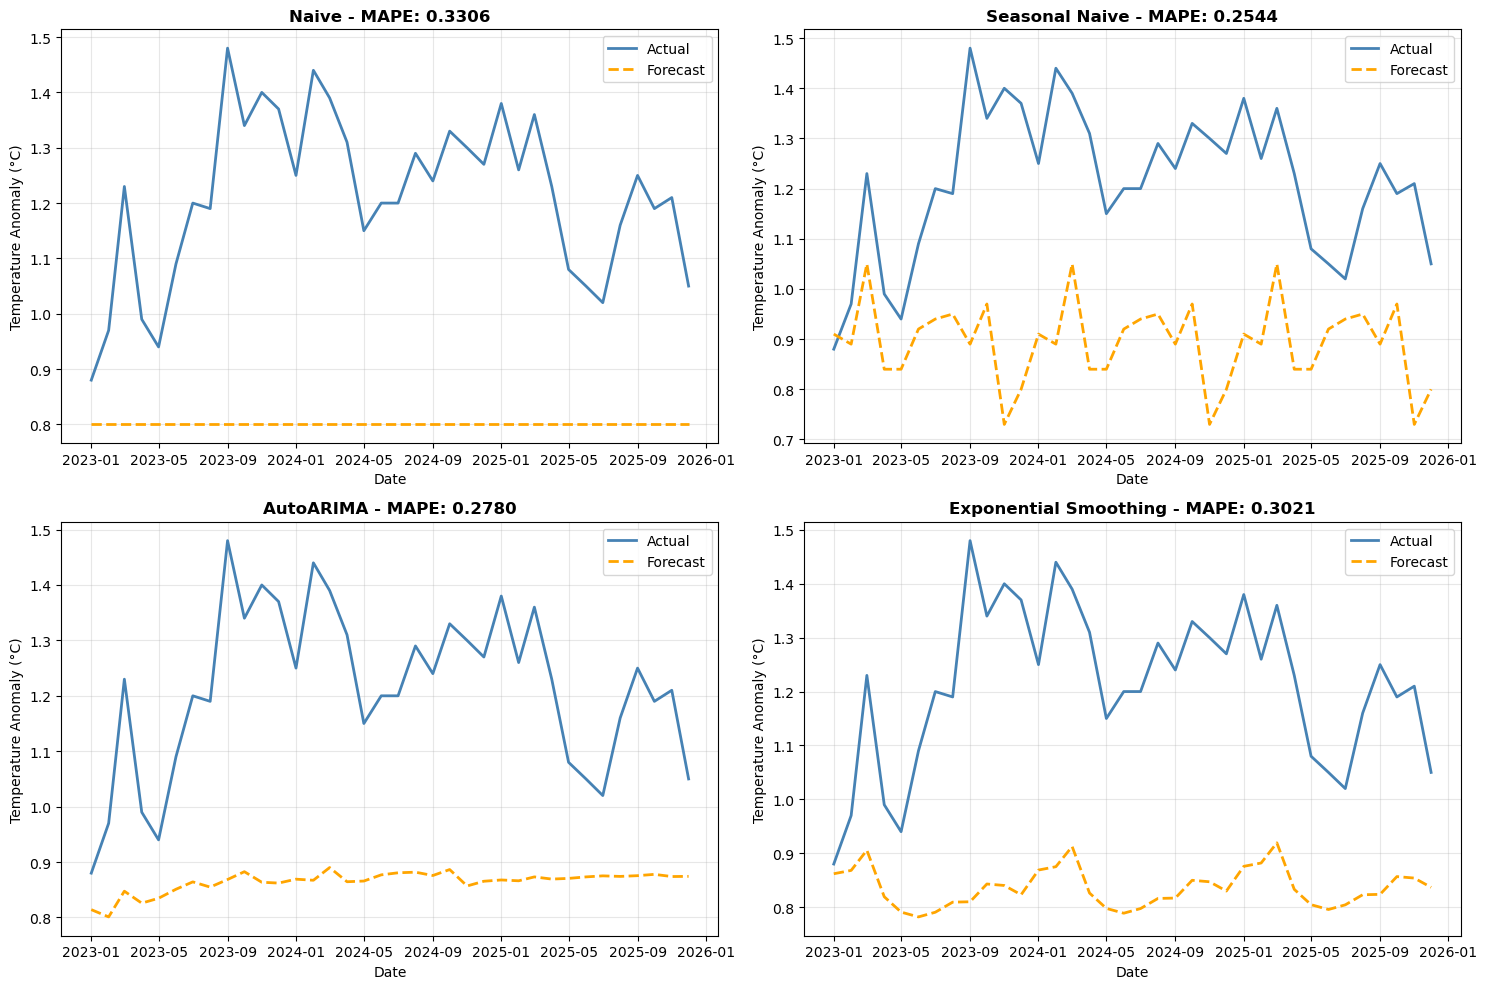

In [19]:
# Print model performance comparison
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON (MAPE)")
print("="*50)
for model_name, mape in sorted(metrics.items(), key=lambda x: x[1]):
    print(f"{model_name:<25} MAPE: {mape:.4f}")

# Visualize predictions vs actual
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (model_name, pred) in enumerate(predictions.items()):
    axes[idx].plot(y_test.index.to_timestamp(), y_test.values, label='Actual', linewidth=2, color='steelblue')
    axes[idx].plot(pred.index.to_timestamp(), pred.values, label='Forecast', linewidth=2, color='orange', linestyle='--')
    axes[idx].set_title(f'{model_name} - MAPE: {metrics[model_name]:.4f}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Temperature Anomaly (°C)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Adding a damped trend often helps with temperature data
damped_model = ExponentialSmoothing(trend="add", seasonal="add", sp=12, damped_trend=True)
damped_model.fit(y_train)
damped_pred = damped_model.predict(fh=range(1, len(y_test) + 1))
damped_mape = mean_absolute_percentage_error(y_test, damped_pred)
print(f"Damped Exponential Smoothing MAPE: {damped_mape:.4f}")


# ... check if this MAPE beats 0.2544


Damped Exponential Smoothing MAPE: 0.3119


In [36]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.transformations.series.detrend import Deseasonalizer

# Theta is great for "noisy" seasonal data
# 1. Create an additive deseasonalizer
deseasonalizer = Deseasonalizer(sp=12, model="additive")

# 2. Transform the data to be "non-seasonal"
y_train_deseasonalized = deseasonalizer.fit_transform(y_train)

# 3. Fit Theta on the cleaned data (disable its internal deseasonalizing)
theta_model = ThetaForecaster(sp=12, deseasonalize=False)
theta_model.fit(y_train_deseasonalized)

theta_pred = theta_model.predict(fh=range(1, len(y_test) + 1))
# Calculate MAPE...
theta_mape = mean_absolute_percentage_error(y_test, theta_pred)
print(f"Theta Forecaster MAPE: {theta_mape:.4f}")

Theta Forecaster MAPE: 0.3103


/home/pocl/miniconda3/envs/ml/lib/python3.11/site-packages/sktime/forecasting/theta.py:128: UserWarning: `sp` in ThetaForecaster is ignored when `deseasonalise`=False
  warn(


In [37]:
# Average the best-performing model with the most "intelligent" one
ensemble_pred = (predictions['Seasonal Naive'] + predictions['AutoARIMA']) / 2

ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_pred)
print(f"Ensemble (S-Naive + AutoARIMA) MAPE: {ensemble_mape:.4f}")


Ensemble (S-Naive + AutoARIMA) MAPE: 0.2653


In [40]:
from sktime.forecasting.fbprophet import Prophet

# Prophet often handles anomalies better than traditional stats models
prophet_model = Prophet()
prophet_model.fit(y_train)
prophet_pred = prophet_model.predict(fh=range(1, len(y_test) + 1))

prophet_mape = mean_absolute_percentage_error(y_test, prophet_pred)
print(f"Prophet MAPE: {prophet_mape:.4f}")


/home/pocl/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
12:53:55 - cmdstanpy - INFO - Chain [1] start processing
12:53:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE: 0.1922


In [41]:
from sktime.forecasting.fbprophet import Prophet

# Increase flexibility (0.15) to see if it captures recent anomalies better
tuned_prophet = Prophet(
    changepoint_prior_scale=0.15, 
    seasonality_mode='additive',
    yearly_seasonality=True
)

tuned_prophet.fit(y_train)
tuned_pred = tuned_prophet.predict(fh=range(1, len(y_test) + 1))

tuned_mape = mean_absolute_percentage_error(y_test, tuned_pred)
print(f"Tuned Prophet MAPE: {tuned_mape:.4f}")


12:55:48 - cmdstanpy - INFO - Chain [1] start processing
12:55:48 - cmdstanpy - INFO - Chain [1] done processing


Tuned Prophet MAPE: 0.1778


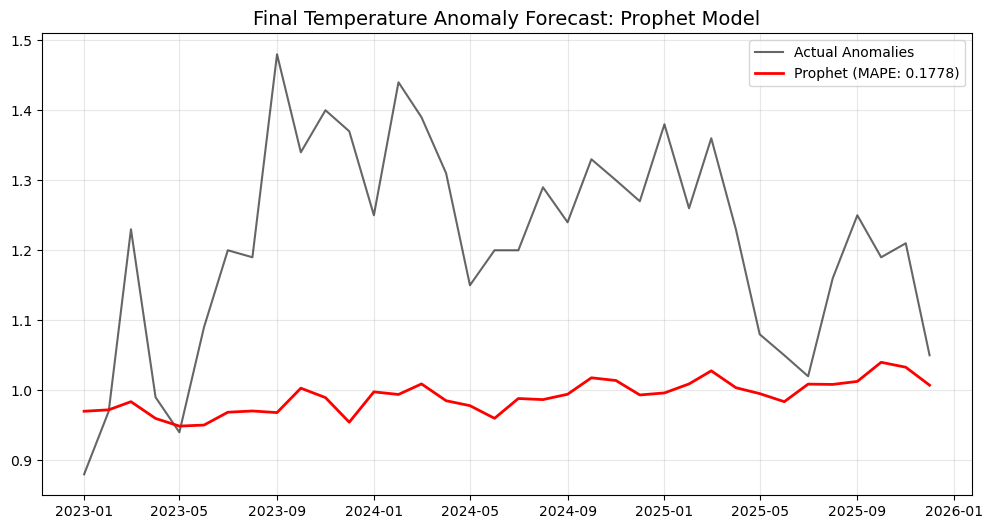

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index.to_timestamp(), y_test.values, label='Actual Anomalies', color='black', alpha=0.6)
plt.plot(tuned_pred.index.to_timestamp(), tuned_pred.values, label=f'Prophet (MAPE: {tuned_mape:.4f})', color='red', linewidth=2)
plt.title('Final Temperature Anomaly Forecast: Prophet Model', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [39]:
!pip install prophet holidays

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 17.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 17.5 MB/s eta 0:00:00
